In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

import os, sys
import networkx as nx

In [2]:
libpath = os.path.abspath('..')
if libpath not in sys.path:
    sys.path.append(libpath)

In [3]:
from qubitrbm.qaoa import QAOA
from qubitrbm.optimize import Optimizer
from qubitrbm.rbm import RBM
from qubitrbm.utils import exact_fidelity

## The setup

Define a graph to run QAOA on:

In [4]:
G = nx.random_regular_graph(d=3, n=12, seed=12345)

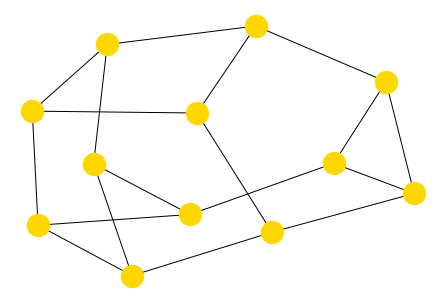

In [5]:
nx.draw_kamada_kawai(G, node_color='gold', node_size=500)

For $p>1$, provided we have a small graph, we can find optimal angles exactly:

In [21]:
qaoa = QAOA(G, p=2)

In [24]:
%%time
angles, costs = qaoa.optimize(init=[np.pi/8, np.pi/8, -np.pi/8, -np.pi/8], tol=1e-4)

Iteration  23 | Cost = -8.7909
Iteration  47 | Cost = -8.9297
CPU times: user 23.3 s, sys: 49.5 ms, total: 23.3 s
Wall time: 23.6 s


Text(0, 0.5, '$\\langle \\mathcal{C} \\rangle $')

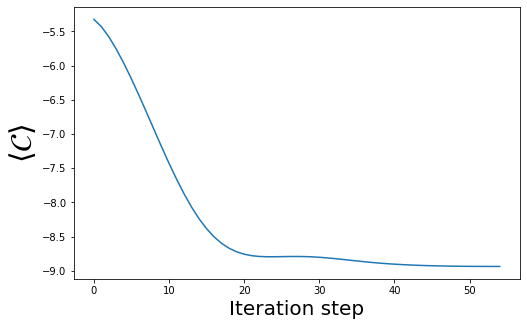

In [26]:
fig, ax = plt.subplots(figsize=[8,5])
ax.plot(costs)
ax.set_xlabel('Iteration step', fontsize=20)
ax.set_ylabel(r'$\langle \mathcal{C} \rangle $', fontsize=30)

In [27]:
gammas, betas = np.split(angles, 2)

In [28]:
gammas[0] # \gamma _1

0.23477311566447656

In [29]:
gammas[1] # \gamma _2

0.4327384898490212

In [30]:
betas[0] # \beta _1

-0.5288937017617381

In [31]:
betas[1] # \beta _2

-0.29518040365543974

Initialize an RBM ansatz with $N=12$ visible units, the same number as the underlying graph

In [32]:
logpsi = RBM(12)

Exactly apply $U_C (\gamma _1) = \exp \left( -i \gamma _1 \sum _{\langle i, j \rangle } Z_i Z_j \right)$

In [33]:
logpsi.UC(G, gamma=gammas[0], mask=False)

The process introduced a number of hidden units $n_h$ that's equal to the number of edges in the graph. (Plus 1 that was there by default when we initialized the RBM.)

We can look at the numbers:

In [34]:
logpsi.nv, logpsi.nh

(12, 19)

In [35]:
logpsi.alpha # = logpsi.nh / logpsi.nv

1.5833333333333333

## The first optimization

Now, initialize the optimizer and approximately apply $U_B (\beta _1) = \exp \left( -i \beta _1 \sum _i X_i \right)$

In [36]:
optim = Optimizer(logpsi, n_steps=800, n_chains=4, warmup=800, step=12)

In [37]:
%%time

for n in range(len(G)):
    params, history = optim.sr_rx(n=n, beta=betas[0], resample_phi=3, verbose=True)
    optim.machine.params = params
    
    print(f'Done with qubit #{n+1}, reached fidelity {history[-1]}')

Iteration   20 | Fidelity = 0.9966 | lr = 0.100 | Diff mean fidelity = 0.0093305
Done with qubit #1, reached fidelity 0.9991241196565062
Done with qubit #2, reached fidelity 0.99925805473567
Done with qubit #3, reached fidelity 0.9989657332878928
Done with qubit #4, reached fidelity 0.9993579262776202
Done with qubit #5, reached fidelity 0.9967361528794774
Iteration   31 | Fidelity = 0.9981 | lr = 0.100 | Diff mean fidelity = 0.0014028
Done with qubit #6, reached fidelity 0.9988350326504564
Done with qubit #7, reached fidelity 0.9973656686719948
Done with qubit #8, reached fidelity 0.9970497856626165
Done with qubit #9, reached fidelity 0.9978048341865592
Done with qubit #10, reached fidelity 0.9963528112629
Iteration   31 | Fidelity = 0.9976 | lr = 0.100 | Diff mean fidelity = 0.0008652
Done with qubit #11, reached fidelity 0.9975955065705118
Done with qubit #12, reached fidelity 0.9965953365501703
CPU times: user 2min 52s, sys: 11.2 s, total: 3min 4s
Wall time: 1min 56s


In [38]:
logpsi.params = params

It's a good check to compare exact fidelities at this point:

In [39]:
psi_exact = QAOA(G, p=1).simulate(gammas[0], betas[0]).final_state_vector
psi_rbm = logpsi.get_state_vector(normalized=True)

In [40]:
exact_fidelity(psi_exact, psi_rbm)

0.9754150697386376

Next, apply

$$U_C (\gamma _2) = \exp \left( -i \gamma _2 \sum _{\langle i, j \rangle } Z_i Z_j \right)$$

In [41]:
logpsi.UC(G, gamma=gammas[1])

In [42]:
optim.machine = logpsi

However, this doubled the number of hidden units:

In [43]:
logpsi.alpha

3.0833333333333335

## The compression step

We can keep the number of hidden units under control as we go to higher values of $p$ by  performing a compression step, as described in the paper.

Essentially, we define a smaller RBM with `RBM.alpha = 1.5` (the previous value or any we choose to compress to). Then, we optimize parameters of the new RBM to describe the same quantum state as the larger one, obtaining a compressed representaion of

$$  \vert \psi \rangle = U_C (\gamma _2) \; U_B (\beta _1) \; U_C(\gamma _1) \; \vert + \rangle  $$

A heuristically good choice for initial RBM parameters are those values that exactly describe the following quantum state:

$$ \vert \psi _\text{init} \rangle = U_C \left( \frac{\gamma_1 + \gamma _2}{2} \right) \; \vert + \rangle  $$

In [44]:
aux = RBM(len(G))
aux.UC(G, (gammas[0] + gammas[1])/2)
init_params = aux.params

Now, perform the compression:

In [49]:
%%time
params, history = optim.sr_compress(init=init_params, resample_phi=2, verbose=True)

Iteration   34 | Fidelity = 0.9950 | lr = 0.100 | Diff mean fidelity = 0.0061196
CPU times: user 21.6 s, sys: 1.39 s, total: 23 s
Wall time: 13.5 s


Let's plot the fidelity as a function of compression optimizer step:

Text(0, 0.5, 'Fidelity')

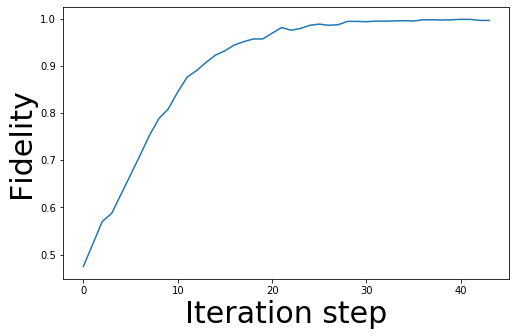

In [50]:
fig, ax = plt.subplots(figsize=[8,5])
ax.plot(history)
ax.set_xlabel('Iteration step', fontsize=30)
ax.set_ylabel('Fidelity', fontsize=30)

Estimated fidelity reached:

In [51]:
history[-1]

0.9960034052541658

In [56]:
logpsi = RBM(12, (len(params) - 12)//(12+1))
logpsi.params = params

In [57]:
logpsi.alpha

1.5833333333333333

Finally, we can apply $U_B (\beta _2) = \exp \left( -i \beta _2 \sum _i X_i \right)$

In [58]:
optim.machine = logpsi

## The second optimization

In [59]:
%%time

for n in range(len(G)):
    params, history = optim.sr_rx(n=n, beta=betas[1], resample_phi=3, verbose=True)
    optim.machine.params = params
    
    print(f'Done with qubit #{n+1}, reached fidelity {history[-1]}')

Done with qubit #1, reached fidelity 0.9936483423240047
Done with qubit #2, reached fidelity 0.9945939003403254
Iteration   33 | Fidelity = 0.9952 | lr = 0.100 | Diff mean fidelity = 0.0023351
Done with qubit #3, reached fidelity 0.9929582465250073
Done with qubit #4, reached fidelity 0.9973711526104884
Iteration   33 | Fidelity = 0.9950 | lr = 0.100 | Diff mean fidelity = 0.0009768
Done with qubit #5, reached fidelity 0.9950055465841054
Iteration   31 | Fidelity = 0.9949 | lr = 0.100 | Diff mean fidelity = 0.0005597
Done with qubit #6, reached fidelity 0.994948074500038
Iteration   32 | Fidelity = 0.9940 | lr = 0.100 | Diff mean fidelity = 0.0004904
Done with qubit #7, reached fidelity 0.993982373382955
Done with qubit #8, reached fidelity 0.9927259787261872
Done with qubit #9, reached fidelity 0.9917465266431491
Done with qubit #10, reached fidelity 0.9851735331537615
Done with qubit #11, reached fidelity 0.9965867032532723
Done with qubit #12, reached fidelity 0.9897891989809056
CPU

And, compare the final output fidelity at $p=2$:

In [60]:
logpsi.params = params 

In [61]:
psi_exact = QAOA(G, p=2).simulate(gammas, betas).final_state_vector
psi_rbm = logpsi.get_state_vector(normalized=True)

In [62]:
exact_fidelity(psi_exact, psi_rbm)

0.9307011283874043